Implement the DPW distance between between two periodicty spectra as described in: Rhythmic similarity of music based on dynamic periodicity warping (https://ieeexplore.ieee.org/document/4518085) by Andre Holzapfel et al.

In [1]:
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load precomputed periodicity spectra
data = dict(np.load("./data/periodicity_spectra/K448orig_120_phrase_boundary.npz", allow_pickle=True))
spectra, xf = data['spectra'], data['xf']

Text(0, 0.5, 'Spectrum')

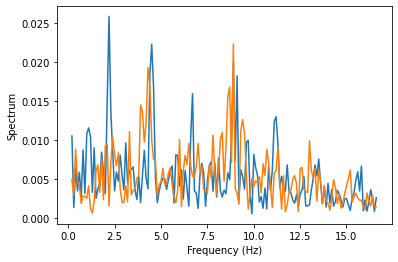

In [2]:
p_1 = spectra[0,:]
p_2 = spectra[-1,:]

plt.plot(xf, p_1)
plt.plot(xf, p_2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Spectrum")

### Difference matrix
$D(i, j)= (\bar{P_1}(f_i) - \bar{P_2}(f_j))^2$

In [3]:
def difference_matrix(p_1, p_2):
    p_1 = np.repeat(np.expand_dims(p_1, 1), len(p_1), axis=1)
    p_2 = np.repeat(np.expand_dims(p_2, 1), len(p_2), axis=1).T
    return np.power(p_1-p_2, 2)

d = difference_matrix(p_1, p_2)

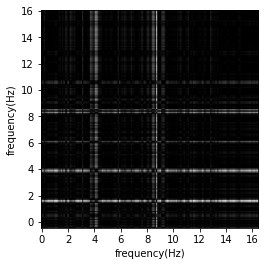

In [4]:
t_frame = 10
ticks = np.arange(0, 16.5, 2).astype(int)
tick_idx = (ticks*t_frame).astype(int)

fig, ax = plt.subplots()

ax.imshow(d[::-1], cmap='gray') # make (0,0) starts from bottom left
ax.set_xticks(ticks=tick_idx, labels=ticks)
ax.set_yticks(ticks=tick_idx, labels=ticks[::-1])
ax.set_xlabel("frequency(Hz)")
ax.set_ylabel("frequency(Hz)")
plt.show()

### Use DP to find lowest cost path through matrix D

In [5]:
def minCostPath(s):
    m, n = s.shape
    cost = np.zeros_like(s) + np.nan

    cost[0, :] = np.cumsum(s[0,:])
    cost[:, 0] = np.cumsum(s[:, 0])
    pos = []

    for i in range(1, m):
        tmp_pos = []
        for j in range(1, n):
            candidate = [cost[i-1,j-1], cost[i-1,j], cost[i,j-1]]
            idx = np.argmin(candidate)
            tmp_pos.append([(i-1,j-1), (i-1,j), (i,j-1)][idx])
            cost[i,j] = candidate[idx] + s[i,j]
        pos.append(tmp_pos)
        
    pos = [[(-1, -1) for _ in range(n-1)]] + pos
    new_pos = [[(-1, -1)] + i for i in pos]
    
    i, j = new_pos[-1][-1]
    path = [[i,j]]
    while i >= 0:
        i, j = new_pos[i][j]
        path.append([i,j])
        
    path = path[::-1]
    return cost, new_pos, np.array(path)

In [6]:
cost, _, path = minCostPath(d)

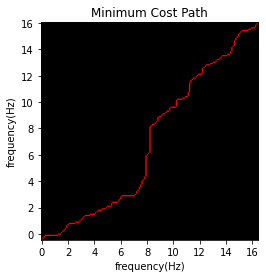

In [17]:
# For visualization
n = len(p_1)
img = np.zeros((n, n, 3))

for x,y in path:
    if x > 0 and y > 0:
        img[x,y,0] = 1
        
fig, ax = plt.subplots()
ax.imshow(img[::-1]) # make (0,0) starts from bottom left
ax.set_xticks(ticks=tick_idx, labels=ticks)
ax.set_yticks(ticks=tick_idx, labels=ticks[::-1])
ax.set_xlabel("frequency(Hz)")
ax.set_ylabel("frequency(Hz)")
ax.set_title("Minimum Cost Path")
plt.show()

### Similarity matrix
$S = \bar{P_1}(f) \otimes \bar{P_2}(f)^T$

Draw a straight line along the diagonal that cross over the local maximum.

In [19]:
def refPath(s, offset=2):
    offsets = (np.arange(-offset, offset+1)).tolist()
    values = [np.diagonal(s, offset=i) for i in offsets]
    tridiagnoal_s = scipy.sparse.diags(values, offsets).toarray()
    
    x, y = np.where(tridiagnoal_s == np.max(tridiagnoal_s))
    coord = np.array([x[0], y[0]])
        
    # find the straight line passing through local maximum    
    delta = abs(x[0] - y[0])
    start = coord - np.min(coord)
    
    path = np.arange(len(s) - delta)
    path = np.repeat(np.expand_dims(path, 1), 2, axis=1)
    
    return path + start

def refPathOffset(s, offset=2):
    offsets = (np.arange(-offset, offset+1)).tolist()
    values = [np.diagonal(s, offset=i) for i in offsets]
    tridiagnoal_s = scipy.sparse.diags(values, offsets).toarray()
    
    x, y = np.where(tridiagnoal_s == np.max(tridiagnoal_s))
    coord = np.array([x[0], y[0]])
        
    # find the straight line passing through local maximum    
    delta = y[0] - x[0]
    return delta

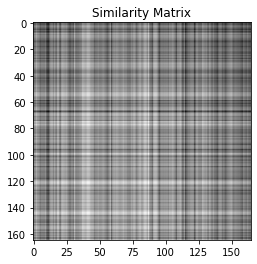

In [20]:
# Calculate similarity matrix
s = np.outer(p_1, p_2)
plt.imshow(np.log(s[::-1,:]), cmap='gray') # move 0,0 to bottome left
plt.title("Similarity Matrix")
plt.show()

# Find the global within certain bandwidth
bpm_res = np.mean(np.diff(xf*60))
bpm_band = 30

rho_offset = refPathOffset(s)
rho = refPath(s, offset=round(bpm_band/2/bpm_res))

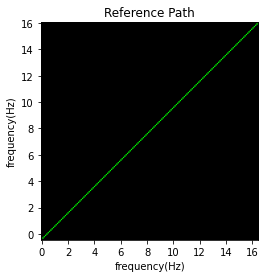

In [24]:
# For visualization
n = len(p_1)
img_ref = np.zeros((n, n, 3))

for x,y in rho:
    if x > 0 and y > 0:
        img_ref[x,y,1] = 1
        
fig, ax = plt.subplots()
ax.imshow(img_ref[::-1]) # make (0,0) starts from bottom left
ax.set_xticks(ticks=tick_idx, labels=ticks)
ax.set_yticks(ticks=tick_idx, labels=ticks[::-1])
ax.set_xlabel("frequency(Hz)")
ax.set_ylabel("frequency(Hz)")
ax.set_title("Reference Path")
plt.show()

### Distance 
Measure the distance of the orthogonal projection of minCostPath on refPath by rotating the path by 45 degree

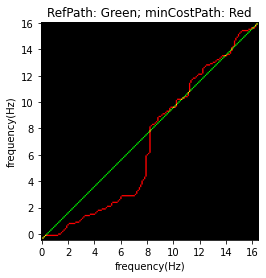

In [28]:
# For visualization
n = len(p_1)
img_dist = np.zeros((n, n, 3))

for x,y in path:
    if x > 0 and y > 0:
        img_dist[x,y,0] = 1

for x,y in rho:
    if x > 0 and y > 0:
        img_dist[x,y,1] = 1
        
fig, ax = plt.subplots()
ax.imshow(img_dist[::-1]) # make (0,0) starts from bottom left
ax.set_xticks(ticks=tick_idx, labels=ticks)
ax.set_yticks(ticks=tick_idx, labels=ticks[::-1])
ax.set_xlabel("frequency(Hz)")
ax.set_ylabel("frequency(Hz)")
plt.title("RefPath: Green; minCostPath: Red")
plt.show()

In [29]:
# Apply rotation matrix
theta = -np.pi/4
rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                       [np.sin(theta), np.cos(theta)]])

rot_path = np.dot(rot_matrix, path.T).T
rot_rho = np.dot(rot_matrix, rho.T).T

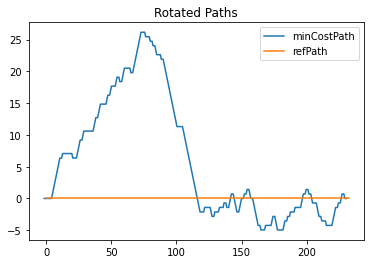

In [32]:
plt.plot(rot_path[:,0], rot_path[:,1], label="minCostPath")
plt.plot(rot_rho[:,0], rot_rho[:,1], label="refPath")
plt.title("Rotated Paths")
plt.legend()
plt.show()

In [33]:
# The distance now becomes the difference in Y
rot_vec = np.array([np.sin(theta), np.cos(theta)])
rot_path_y = np.dot(rot_vec, path.T)
rot_rho_y = rho_offset * np.cos(theta)
avg_proj_dist = np.mean(np.abs(rot_path_y - rot_rho_y))